In [1]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

In [2]:
from scapy.all import sniff

# Función para capturar paquetes
def capture_packets():
    packets = sniff(count=25)  # Captura 25 paquetes
    return packets

captured_packets = capture_packets()


In [3]:
print("Tipo de la variable:", type(captured_packets))  # Tipo de la variable
print("Longitud de la variable:" ,len(captured_packets))   # Longitud de la variable
print("Contenido de la variable:" , captured_packets)        # Contenido de la variable


Tipo de la variable: <class 'scapy.plist.PacketList'>
Longitud de la variable: 25
Contenido de la variable: <Sniffed: TCP:22 UDP:0 ICMP:0 Other:3>


In [4]:
print(type(captured_packets[0]))  # Tipo de dato del primer paquete


<class 'scapy.layers.l2.Ether'>


In [5]:
for packet in captured_packets[:5]:
    print(packet)
    print("------")


Ether / IP / TCP 192.168.0.12:56050 > 192.168.0.2:8009 A
------
Ether / IPv6 / ICMPv6ND_RA / ICMPv6NDOptRDNSS / ICMPv6NDOptPrefixInfo / ICMPv6 Neighbor Discovery Option - Source Link-Layer Address 94:8f:cf:9c:e6:6b
------
Ether / fe80::10f9:a1bd:4f18:67bd > ff02::16 (0) / IPv6ExtHdrHopByHop / ICMPv6MLReport2
------
Ether / IP / TCP 192.168.0.12:57556 > 13.78.111.198:https S
------
Ether / IP / TCP 140.82.113.25:https > 192.168.0.12:57396 PA / Raw
------


In [10]:
from scapy.all import rdpcap, IP, TCP, UDP, Raw
import pandas as pd

paquete_pcap = rdpcap("analisis_paquetes.pcap")


datos_paquetes = []


for packet in paquete_pcap:
    
    tiempo = packet.time
    src_address = packet[IP].src if IP in packet else None
    dst_address = packet[IP].dst if IP in packet else None

    if TCP in packet:
        src_port = packet[TCP].sport
        dst_port = packet[TCP].dport
    elif UDP in packet:
        src_port = packet[UDP].sport
        dst_port = packet[UDP].dport
    else:
        src_port = None
        dst_port = None

    payload = len(packet[Raw].load) if Raw in packet else 0


    datos_paquetes.append({
        'Time': tiempo,
        'Src Address': src_address,
        'Dst Address': dst_address,
        'Src Port': src_port,
        'Dst Port': dst_port,
        'Payload': payload
    })

df = pd.DataFrame(datos_paquetes)

print(df.head())


                Time  Src Address  Dst Address  Src Port  Dst Port  Payload
0  1532199330.917674   10.1.10.53  84.54.22.33        53        53      905
1  1532199330.950107  84.54.22.33   10.1.10.53        53        53        0
2  1532199331.937777   10.1.10.53  84.54.22.33        53        53      919
3  1532199331.956635  84.54.22.33   10.1.10.53        53        53        0
4  1532199332.960504   10.1.10.53  84.54.22.33        53        53      956


In [11]:
import pandas as pd

# Asumiendo que 'df' es tu DataFrame con los datos

# a. Mostrar todas las IP origen
print("Todas las IP origen:")
print(df['Src Address'].unique())

# b. Mostrar todas las IP destino
print("\nTodas las IP destino:")
print(df['Dst Address'].unique())

# c. Identificar la IP origen más frecuente
most_frequent_src_ip = df['Src Address'].mode()[0]
print("\nIP origen más frecuente:", most_frequent_src_ip)

# i. ¿A qué IP destino se comunica con más frecuencia?
most_common_dst_ip = df[df['Src Address'] == most_frequent_src_ip]['Dst Address'].mode()[0]
print("IP destino más frecuente para la IP origen más frecuente:", most_common_dst_ip)

# ii. ¿A qué puerto destino se comunica?
most_common_dst_port = df[df['Src Address'] == most_frequent_src_ip]['Dst Port'].mode()[0]
print("Puerto destino más frecuente:", most_common_dst_port)

# Descripción del puerto más común, se necesita saber el puerto para especificar
if most_common_dst_port == 80:
    port_description = "HTTP - usado comúnmente para tráfico web no seguro"
elif most_common_dst_port == 443:
    port_description = "HTTPS - usado para tráfico web seguro"
else:
    port_description = "Puerto no estándar o específico de una aplicación"
print("Propósito del puerto más frecuente:", port_description)

# iii. ¿Desde qué puertos origen se comunica?
src_ports = df[df['Src Address'] == most_frequent_src_ip]['Src Port'].unique()
print("Puertos origen desde los que se comunica la IP más frecuente:", src_ports)


Todas las IP origen:
['10.1.10.53' '84.54.22.33' '75.75.75.75']

Todas las IP destino:
['84.54.22.33' '10.1.10.53' '75.75.75.75']

IP origen más frecuente: 10.1.10.53
IP destino más frecuente para la IP origen más frecuente: 84.54.22.33
Puerto destino más frecuente: 53
Propósito del puerto más frecuente: Puerto no estándar o específico de una aplicación
Puertos origen desde los que se comunica la IP más frecuente: [   53 15812 23903]


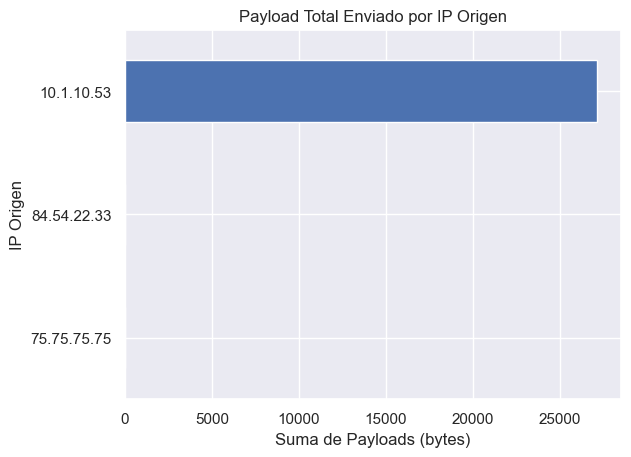

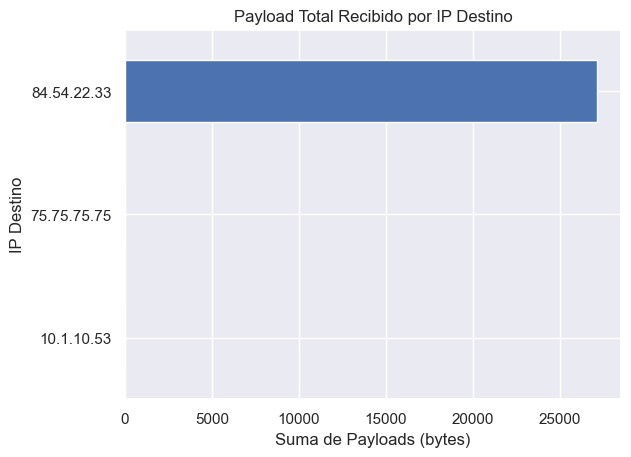

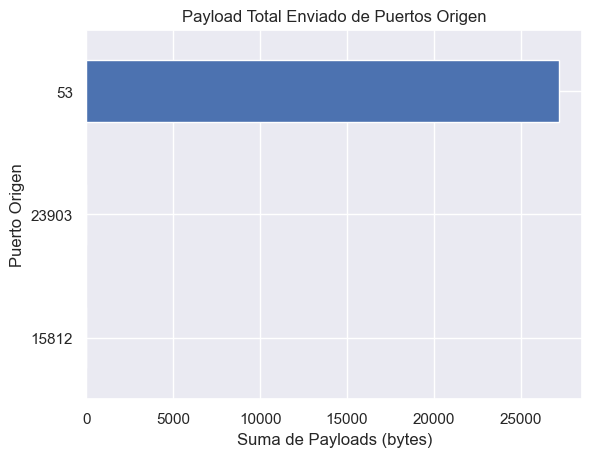

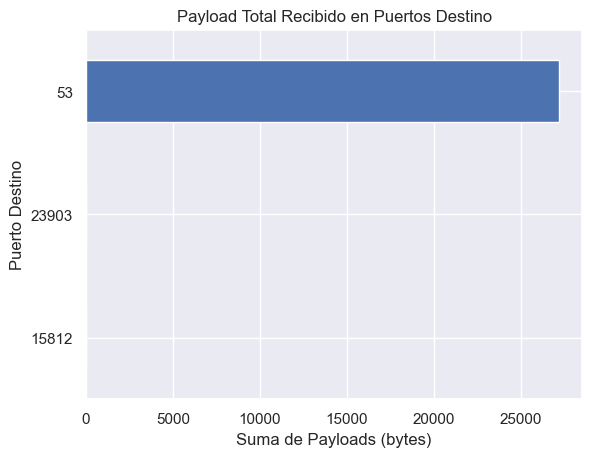

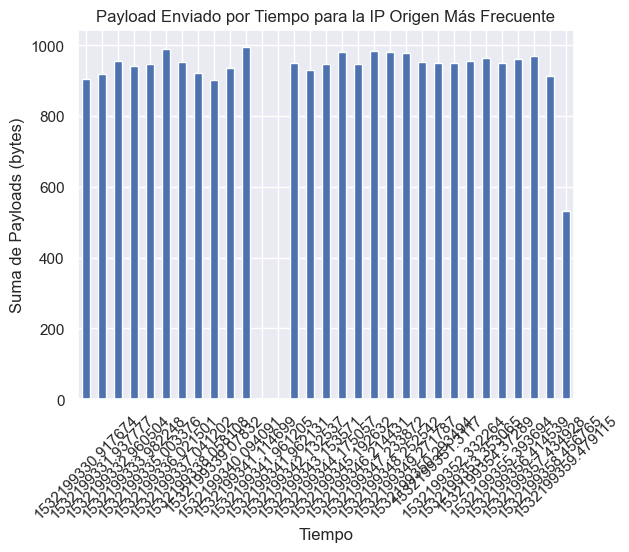

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

df['Time'] = df['Time'].astype(float)

# Gráfica de barras horizontales para IPs origen con suma de payloads
df.groupby('Src Address')['Payload'].sum().sort_values().plot(kind='barh', title='Payload Total Enviado por IP Origen')
plt.xlabel('Suma de Payloads (bytes)')
plt.ylabel('IP Origen')
plt.show()

# Gráfica de barras horizontales para IPs destino con suma de payloads
df.groupby('Dst Address')['Payload'].sum().sort_values().plot(kind='barh', title='Payload Total Recibido por IP Destino')
plt.xlabel('Suma de Payloads (bytes)')
plt.ylabel('IP Destino')
plt.show()

# Gráfica de barras horizontales para puertos origen con suma de payloads
df.groupby('Src Port')['Payload'].sum().sort_values().plot(kind='barh', title='Payload Total Enviado de Puertos Origen')
plt.xlabel('Suma de Payloads (bytes)')
plt.ylabel('Puerto Origen')
plt.show()

# Gráfica de barras horizontales para puertos destino con suma de payloads
df.groupby('Dst Port')['Payload'].sum().sort_values().plot(kind='barh', title='Payload Total Recibido en Puertos Destino')
plt.xlabel('Suma de Payloads (bytes)')
plt.ylabel('Puerto Destino')
plt.show()

# Gráfica de barras verticales para la IP origen más frecuente
most_frequent_src_ip = df['Src Address'].mode()[0]
df[df['Src Address'] == most_frequent_src_ip].groupby('Time')['Payload'].sum().plot(kind='bar', title='Payload Enviado por Tiempo para la IP Origen Más Frecuente')
plt.xlabel('Tiempo')
plt.ylabel('Suma de Payloads (bytes)')
plt.xticks(rotation=45)
plt.show()

In [15]:
most_frequent_src_ip = df['Src Address'].mode()[0]

# Crear un nuevo DataFrame con todas las conexiones donde esta IP es el origen
df_frequent_src = df[df['Src Address'] == most_frequent_src_ip]

In [16]:
# Crear un nuevo DataFrame con las columnas necesarias y agrupar
df_grouped = df_frequent_src[['Src Address', 'Dst Address', 'Payload']].groupby('Dst Address').sum().reset_index()

In [17]:
# Obtener la IP destino con la mayor suma de payload
suspicious_dst_ip = df_grouped[df_grouped['Payload'] == df_grouped['Payload'].max()]['Dst Address'].iloc[0]
print("IP destino sospechosa:", suspicious_dst_ip)


IP destino sospechosa: 84.54.22.33


In [28]:
# Filtrar las conversaciones entre la IP más frecuente y la IP sospechosa
df_conversation = df_frequent_src[df_frequent_src['Dst Address'] == suspicious_dst_ip]
df_conversation.head()

,Time,Src Address,Dst Address,Src Port,Dst Port,Payload
0,1.532199e+09,10.1.10.53,84.54.22.33,53,53,905
2,1.532199e+09,10.1.10.53,84.54.22.33,53,53,919
4,1.532199e+09,10.1.10.53,84.54.22.33,53,53,956
6,1.532199e+09,10.1.10.53,84.54.22.33,53,53,942
8,1.532199e+09,10.1.10.53,84.54.22.33,53,53,947


In [30]:
array_payloads = df_conversation['Payload'].values

print(array_payloads)

[905 919 956 942 947 989 952 923 903 936 995 950 930 948 981 948 983 981
 979 954 950 950 957 963 949 961 971 913 532]


In [32]:

for i, payload in enumerate(array_payloads):
    print(f"Payload {i+1}: {binascii.hexlify(df_conversation.iloc[i]['Payload'])[:10]}")


Payload 1: b'8903000000'
Payload 2: b'9703000000'
Payload 3: b'bc03000000'
Payload 4: b'ae03000000'
Payload 5: b'b303000000'
Payload 6: b'dd03000000'
Payload 7: b'b803000000'
Payload 8: b'9b03000000'
Payload 9: b'8703000000'
Payload 10: b'a803000000'
Payload 11: b'e303000000'
Payload 12: b'b603000000'
Payload 13: b'a203000000'
Payload 14: b'b403000000'
Payload 15: b'd503000000'
Payload 16: b'b403000000'
Payload 17: b'd703000000'
Payload 18: b'd503000000'
Payload 19: b'd303000000'
Payload 20: b'ba03000000'
Payload 21: b'b603000000'
Payload 22: b'b603000000'
Payload 23: b'bd03000000'
Payload 24: b'c303000000'
Payload 25: b'b503000000'
Payload 26: b'c103000000'
Payload 27: b'cb03000000'
Payload 28: b'9103000000'
Payload 29: b'1402000000'


g. Observar contenido y describir lo que se encontro



Los datos transmitidos son consistentes, los primeros dos caracteres varian debido a que este puede identificarse como un identificador de secuencia. Pudiendo ser esto una señal de actividad de aplicación regular. 